In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from np import NeuralProcess
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import split_context_target

from metalearning_benchmarks.sinusoid1d_benchmark import Sinusoid1D
from metalearning_benchmarks.quadratic1d_benchmark import Quadratic1D
from adapter import MetaLearningBenchmarkDatasetAdapter

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [3]:
benchmark = Sinusoid1D(
    n_task=2048,
    n_datapoints_per_task=128,
    output_noise=0.01,
    seed_task=1235, 
    seed_x=123, 
    seed_noise=1237
)
dataset = MetaLearningBenchmarkDatasetAdapter(benchmark)
dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True, num_workers=10)
gen_dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=10)

Generating tasks: 100%|██████████| 2048/2048 [00:00<00:00, 193855.58it/s]


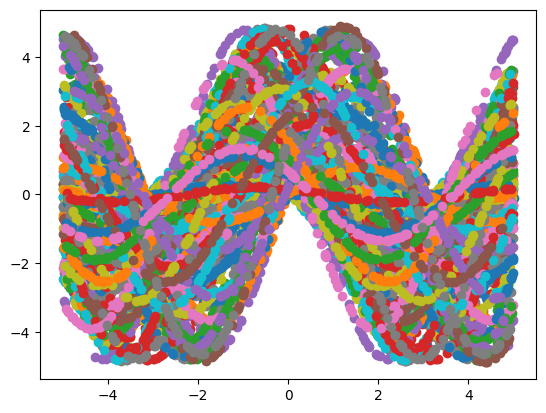

In [4]:
batch = next(iter(dataloader))
for i in range(batch[0].shape[0]):
    x = batch[0][i,:,0]
    y = batch[1][i,:,0]
    plt.scatter(x, y)
plt.show()    

In [5]:
batch = next(iter(dataloader))
sequence = torch.cat(batch, dim=-1)
print(sequence.shape)

context, target = split_context_target(sequence, 0.3)
print(context.shape)
print(target.shape)
# print(target[:, :, 0:1])

torch.Size([128, 128, 2])
torch.Size([128, 38, 2])
torch.Size([128, 90, 2])


In [6]:
x_dim = 1
y_dim = 1

r_dim = 8
z_dim = 8
h_dim = 64

model = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim).to(device)
# model.load_state_dict(torch.load('np.pth'))

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

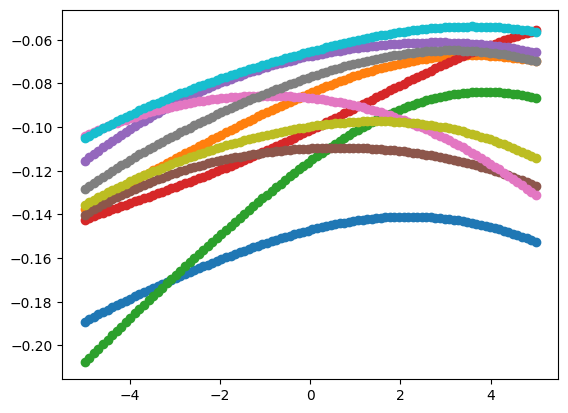

In [7]:
x_target = torch.Tensor(np.linspace(-5, 5, 100)).to(device)
x_target = x_target.unsqueeze(1).repeat(10, 1, 1)
z_sample = torch.randn(10, z_dim).to(device)
mu, logvar = model.decode(z_sample, x_target)

for i in range(x_target.shape[0]):
    x = x_target[i, :, 0].detach().cpu().numpy()
    y = mu[i, :, 0].detach().cpu().numpy()
    plt.scatter(x, y)
plt.show()

In [8]:
recon_criterion = nn.MSELoss(reduction='mean')

def kl_criterion(mu_D, logvar_D, mu_C, logvar_C):
    # (batch_size, z_dim)

    k = mu_D.size(1)
    term1 = (logvar_D.exp() / logvar_C.exp()).sum(1)
    term2 = (logvar_C - logvar_D).sum(1)
    term3 = ((mu_D - mu_C).pow(2) / logvar_C.exp()).sum(1)
    kl = 0.5 * torch.mean(term1 + term2 + term3 - k)
    
    return kl

# def kl_criterion(mu_D, logvar_D, mu_C, logvar_C, eps=1e-6):
#     # (batch_size, z_dim)

#     # Clipping log variances to prevent numerical instabilities
#     logvar_D_clipped = torch.clamp(logvar_D, min=-10.0, max=10.0)
#     logvar_C_clipped = torch.clamp(logvar_C, min=-10.0, max=10.0)

#     k = mu_D.size(1)
    
#     # Compute terms with added stability
#     term1 = (logvar_D_clipped.exp() / (logvar_C_clipped.exp() + eps)).sum(1)
#     term2 = (logvar_C_clipped - logvar_D_clipped).sum(1)
#     term3 = ((mu_D - mu_C).pow(2) / (logvar_C_clipped.exp() + eps)).sum(1)
    
#     kl = 0.5 * (term1 + term2 + term3 - k) # Per-sample KL divergence
    
#     return torch.sum(kl)  

In [9]:
recon_losses = []
kl_losses = []

In [10]:
num_epochs = 64

torch.autograd.set_detect_anomaly(True)

model.train()
with torch.inference_mode(False):

    for epoch in range(num_epochs):

        loop = tqdm(enumerate(dataloader), total=len(dataloader))

        for step, batch in loop:
            
            # forward
            factor = max(min(0.9, np.random.random()), 0.1) 
            sequence = torch.cat(batch, dim=-1).to(device)
            context, target = split_context_target(sequence, factor)

            z, mu_D, logvar_D = model.encode(sequence)
            _, mu_C, logvar_C = model.encode(context)

            mu, logvar = model.decode(z, target[:, :, 0:1])

            # loss
            recon_loss = recon_criterion(mu, target[:, :, 1:2])
            kl_loss = kl_criterion(mu_D, logvar_D, mu_C, logvar_C) # torch.tensor(0.0) # 
            loss = recon_loss + kl_loss

            # stats
            recon_losses.append(recon_loss.item())
            kl_losses.append(kl_loss.item())
            loop.set_postfix(recon_loss=recon_loss.item(), kl_loss=kl_loss.item(), loss=loss.item(), factor=factor)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

  0%|          | 0/16 [00:00<?, ?it/s, factor=0.272, kl_loss=0.000537, loss=3.8, recon_loss=3.8]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
100%|██████████| 16/16 [00:04<00:00,  3.52it/s, factor=0.9, kl_loss=0.00974, loss=0.435, recon_loss=0.425] 


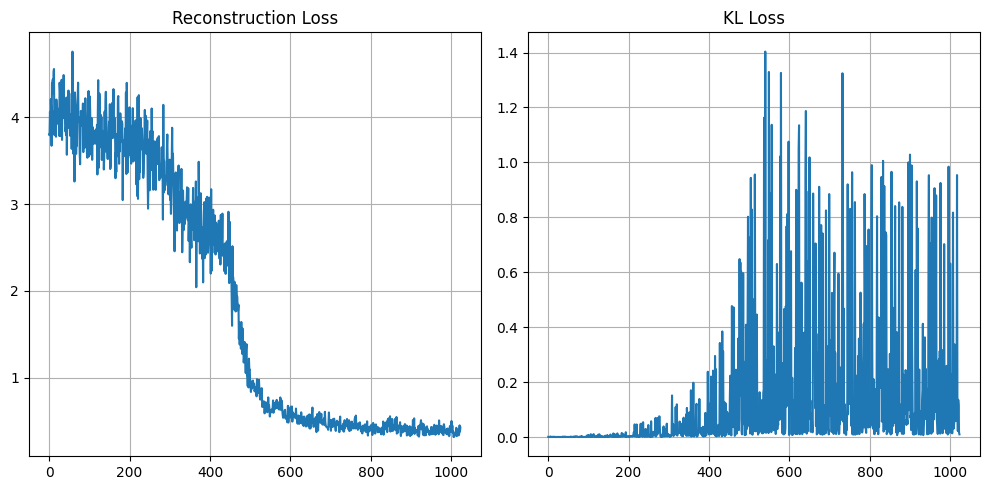

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(recon_losses)
ax[0].set_title('Reconstruction Loss')
ax[0].grid()
 
ax[1].plot(kl_losses)
ax[1].set_title('KL Loss')
ax[1].grid()

plt.tight_layout()
plt.show()

In [12]:
mus = []
vars = []

for i, (batch) in tqdm(enumerate(gen_dataloader), total=1000):
    sequence = torch.cat(batch, dim=-1).to(device)
    context, target = split_context_target(sequence, 0.5)
    
    z, mu_D, logvar_D = model.encode(sequence)
    mus.append(mu_D.cpu().detach().numpy())
    vars.append(logvar_D.cpu().detach().numpy())

    if i > 1000:
        break

1001it [00:06, 149.31it/s]                         


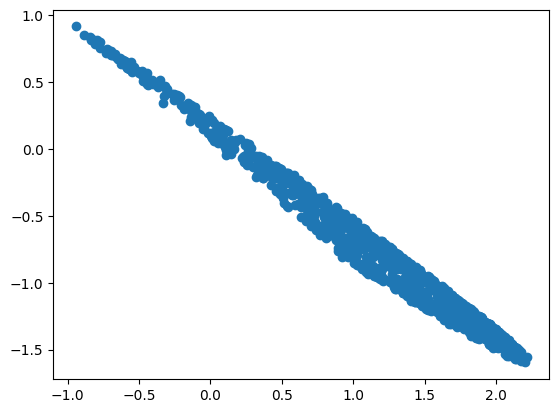

In [17]:
plt.scatter([m[0][0] for m in mus], [m[0][4] for m in mus])
plt.show()

torch.Size([1, 64, 1])
torch.Size([1, 64, 2])


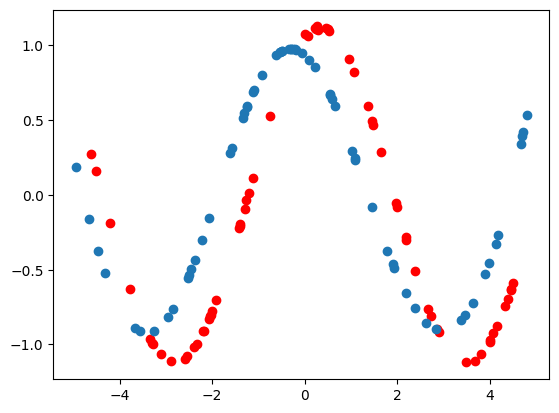

In [44]:
sample = next(iter(gen_dataloader))
sequence = torch.cat(sample, dim=-1).to(device)
factor = 0.5# max(min(0.9, np.random.random()), 0.1)
context, target = split_context_target(sequence, factor)

n_samples = 1

mus, logvars, _, _ = model.sample(context, target[:, :, 0:1], n_samples)
print(mus[0].shape)
print(target.shape)
plt.scatter(context[0, :, 0].cpu().detach().numpy(), context[0, :, 1].cpu().detach().numpy(), c="red")

for i in range(n_samples):
    x = target[0, :, 0].cpu().detach().numpy()
    y = mus[i][0, :, 0].cpu().detach().numpy()
    plt.scatter(x, y)

plt.show()

In [49]:
torch.save(model.state_dict(), 'np.pth')